In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load data
print("Loading data...")
df = pd.read_csv('/kaggle/input/movie-recomendation-fall-2020/train.txt', sep='\t', header=None, names=['user_id', 'movie_id', 'rating'])

print(f"Dataset shape: {df.shape}")
print(f"Number of unique users: {df['user_id'].nunique()}")
print(f"Number of unique movies: {df['movie_id'].nunique()}")
print(f"Rating range: {df['rating'].min()} - {df['rating'].max()}")

# Preprocessing
user_ids = df['user_id'].unique()
item_ids = df['movie_id'].unique()

user_encoder = {user: idx for idx, user in enumerate(user_ids)}
item_encoder = {item: idx for idx, item in enumerate(item_ids)}

df['user_idx'] = df['user_id'].map(user_encoder)
df['item_idx'] = df['movie_id'].map(item_encoder)

num_users = len(user_encoder)
num_items = len(item_encoder)

print(f"Encoded users: {num_users}, Encoded items: {num_items}")

# Prepare data
users = df['user_idx'].values
items = df['item_idx'].values
ratings = df['rating'].values.astype(np.float32)

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    np.column_stack([users, items]), ratings, test_size=0.2, random_state=42, shuffle=True
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")

# Create Dataset class
class RatingDataset(Dataset):
    def __init__(self, users, items, ratings):
        self.users = torch.LongTensor(users)
        self.items = torch.LongTensor(items)
        self.ratings = torch.FloatTensor(ratings)
    
    def __len__(self):
        return len(self.ratings)
    
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

# Create data loaders
train_dataset = RatingDataset(X_train[:, 0], X_train[:, 1], y_train)
val_dataset = RatingDataset(X_val[:, 0], X_val[:, 1], y_val)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
# NeuMF Model
# Training function
# Evaluation function

Using device: cpu
Loading data...
Dataset shape: (90570, 3)
Number of unique users: 943
Number of unique movies: 1680
Rating range: 1 - 5
Encoded users: 943, Encoded items: 1680
Training set: 72456 samples
Validation set: 18114 samples


In [3]:
class ImprovedNeuMF(nn.Module):
    def __init__(self, num_users, num_items, mf_embedding=32, mlp_embedding=32, 
                 hidden_layers=[64, 32, 16], dropout_rate=0.2, use_batch_norm=True,
                 use_layer_norm=False, fusion_method='concat'):
        super(ImprovedNeuMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.mf_embedding = mf_embedding
        self.mlp_embedding = mlp_embedding
        self.dropout_rate = dropout_rate
        self.use_batch_norm = use_batch_norm
        self.use_layer_norm = use_layer_norm
        self.fusion_method = fusion_method   #'concat', 'sum', 'gate'
        
        # GMF Embeddings với padding index
        self.mf_user_embedding = nn.Embedding(num_users, mf_embedding, padding_idx=0)
        self.mf_item_embedding = nn.Embedding(num_items, mf_embedding, padding_idx=0)
        
        # MLP Embeddings với padding index
        self.mlp_user_embedding = nn.Embedding(num_users, mlp_embedding, padding_idx=0)
        self.mlp_item_embedding = nn.Embedding(num_items, mlp_embedding, padding_idx=0)
        
        # MLP Layers với BatchNorm/LayerNorm
        self.mlp_layers = nn.ModuleList()
        input_size = mlp_embedding * 2
        
        for i, hidden_size in enumerate(hidden_layers):
            # Linear layer
            self.mlp_layers.append(nn.Linear(input_size, hidden_size))
            # Batch Normalization
            if use_batch_norm:
                self.mlp_layers.append(nn.BatchNorm1d(hidden_size))
            # Layer Normalization (alternative)
            if use_layer_norm and not use_batch_norm:
                self.mlp_layers.append(nn.LayerNorm(hidden_size))
            # Activation
            self.mlp_layers.append(nn.ReLU())
            # Dropout
            self.mlp_layers.append(nn.Dropout(dropout_rate))
            input_size = hidden_size
        # Gating mechanism cho fusion
        if fusion_method == 'gate':
            self.gate_layer = nn.Linear(mf_embedding + hidden_layers[-1], 2)
            self.gate_activation = nn.Softmax(dim=-1)
        
        # Attention mechanism cho interaction features
        self.attention = nn.Sequential(
            nn.Linear(mf_embedding, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
        # Final output layer với skip connection
        final_input_size = mf_embedding + hidden_layers[-1]
        self.output_layer = nn.Sequential(
            nn.Linear(final_input_size, final_input_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(final_input_size // 2, 1)
        )
        
        # Residual connection
        self.residual = nn.Linear(final_input_size, 1) if fusion_method == 'residual' else None
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        # Initialize embedding weights với phân phối uniform
        nn.init.uniform_(self.mf_user_embedding.weight, a=-0.05, b=0.05)
        nn.init.uniform_(self.mf_item_embedding.weight, a=-0.05, b=0.05)
        nn.init.uniform_(self.mlp_user_embedding.weight, a=-0.05, b=0.05)
        nn.init.uniform_(self.mlp_item_embedding.weight, a=-0.05, b=0.05)
        
        # Khởi tạo embedding cho padding index = 0
        with torch.no_grad():
            self.mf_user_embedding.weight[0].fill_(0)
            self.mf_item_embedding.weight[0].fill_(0)
            self.mlp_user_embedding.weight[0].fill_(0)
            self.mlp_item_embedding.weight[0].fill_(0)
        
        # Initialize MLP layers với Kaiming initialization cho ReLU
        for layer in self.mlp_layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0.0)
        
        # Initialize output layer
        for layer in self.output_layer:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0.0)
    
    def forward(self, user_indices, item_indices):
        # GMF path với attention
        mf_user_embedded = self.mf_user_embedding(user_indices)
        mf_item_embedded = self.mf_item_embedding(item_indices)
        mf_vector = mf_user_embedded * mf_item_embedded  # Element-wise product
        
        # Áp dụng attention cho interaction features
        attention_weights = self.attention(mf_vector)
        mf_vector = mf_vector * attention_weights
        
        # MLP path
        mlp_user_embedded = self.mlp_user_embedding(user_indices)
        mlp_item_embedded = self.mlp_item_embedding(item_indices)
        mlp_vector = torch.cat([mlp_user_embedded, mlp_item_embedded], dim=-1)
        
        # Forward qua MLP layers
        for layer in self.mlp_layers:
            mlp_vector = layer(mlp_vector)
        
        # Feature fusion với các phương thức khác nhau
        if self.fusion_method == 'concat':
            concat_vector = torch.cat([mf_vector, mlp_vector], dim=-1)
            output = self.output_layer(concat_vector)
        
        elif self.fusion_method == 'sum':
            # Chuẩn hóa về cùng chiều trước khi cộng
            if mf_vector.size(-1) != mlp_vector.size(-1):
                mf_proj = nn.Linear(mf_vector.size(-1), mlp_vector.size(-1)).to(mf_vector.device)
                mf_vector = mf_proj(mf_vector)
            combined = mf_vector + mlp_vector
            output = self.output_layer(combined)
        
        elif self.fusion_method == 'gate':
            concat_vector = torch.cat([mf_vector, mlp_vector], dim=-1)
            gate_values = self.gate_activation(self.gate_layer(concat_vector))
            gated_mf = mf_vector * gate_values[:, 0:1]
            gated_mlp = mlp_vector * gate_values[:, 1:2]
            combined = torch.cat([gated_mf, gated_mlp], dim=-1)
            output = self.output_layer(combined)
        
        elif self.fusion_method == 'residual':
            concat_vector = torch.cat([mf_vector, mlp_vector], dim=-1)
            main_output = self.output_layer(concat_vector)
            residual_output = self.residual(concat_vector)
            output = main_output + residual_output
        
        # Áp dụng sigmoid nếu là bài toán binary classification
        # output = torch.sigmoid(output)  # Uncomment nếu cần
        
        return output.squeeze()
    
    def get_embeddings(self, user_indices):
        """Lấy embeddings của user để sử dụng cho visualization hoặc similarity"""
        mf_user_emb = self.mf_user_embedding(user_indices)
        mlp_user_emb = self.mlp_user_embedding(user_indices)
        return torch.cat([mf_user_emb, mlp_user_emb], dim=-1)

In [4]:
# Training function
def train_model(model, train_loader, val_loader, epochs=30, learning_rate=0.001):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for batch_idx, (users, items, ratings) in enumerate(train_loader):
            users = users.to(device)
            items = items.to(device)
            ratings = ratings.to(device)
            
            optimizer.zero_grad()
            predictions = model(users, items)
            loss = criterion(predictions, ratings)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []
        
        with torch.no_grad():
            for users, items, ratings in val_loader:
                users = users.to(device)
                items = items.to(device)
                ratings = ratings.to(device)
                
                predictions = model(users, items)
                loss = criterion(predictions, ratings)
                val_loss += loss.item()
                
                val_predictions.extend(predictions.cpu().numpy())
                val_targets.extend(ratings.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Calculate RMSE
        val_rmse = np.sqrt(mean_squared_error(val_targets, val_predictions))
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_neumf_model.pth')
        else:
            patience_counter += 1
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val RMSE: {val_rmse:.4f}')
        print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f}, Patience: {patience_counter}/{patience}')
        
         # if patience_counter >= patience:
         #    print("Early stopping triggered!")
         #    break
    
    # Load best model
    model.load_state_dict(torch.load('best_neumf_model.pth'))
    return model, train_losses, val_losses

In [5]:
# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    targets = []
    
    with torch.no_grad():
        for users, items, ratings in data_loader:
            users = users.to(device)
            items = items.to(device)
            ratings = ratings.to(device)
            
            preds = model(users, items)
            predictions.extend(preds.cpu().numpy())
            targets.extend(ratings.cpu().numpy())
    
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = np.mean(np.abs(np.array(targets) - np.array(predictions)))
    
    return rmse, mae, predictions, targets

Building NeuMF model...
Model parameters: 176,610
Training model...
Epoch 1/30:
  Train Loss: 3.7946, Val Loss: 1.4780, Val RMSE: 1.2160
  LR: 0.001000, Patience: 0/5
Epoch 2/30:
  Train Loss: 1.8154, Val Loss: 1.2058, Val RMSE: 1.0984
  LR: 0.001000, Patience: 0/5
Epoch 3/30:
  Train Loss: 1.4183, Val Loss: 0.9895, Val RMSE: 0.9951
  LR: 0.001000, Patience: 0/5
Epoch 4/30:
  Train Loss: 1.1011, Val Loss: 0.9715, Val RMSE: 0.9860
  LR: 0.001000, Patience: 0/5
Epoch 5/30:
  Train Loss: 0.8730, Val Loss: 0.9614, Val RMSE: 0.9808
  LR: 0.001000, Patience: 0/5
Epoch 6/30:
  Train Loss: 0.7423, Val Loss: 0.9854, Val RMSE: 0.9930
  LR: 0.001000, Patience: 1/5
Epoch 7/30:
  Train Loss: 0.6642, Val Loss: 1.0165, Val RMSE: 1.0085
  LR: 0.001000, Patience: 2/5
Epoch 8/30:
  Train Loss: 0.6082, Val Loss: 1.0540, Val RMSE: 1.0270
  LR: 0.001000, Patience: 3/5
Epoch 9/30:
  Train Loss: 0.5677, Val Loss: 1.0862, Val RMSE: 1.0425
  LR: 0.000500, Patience: 4/5
Epoch 10/30:
  Train Loss: 0.5175, Val Lo

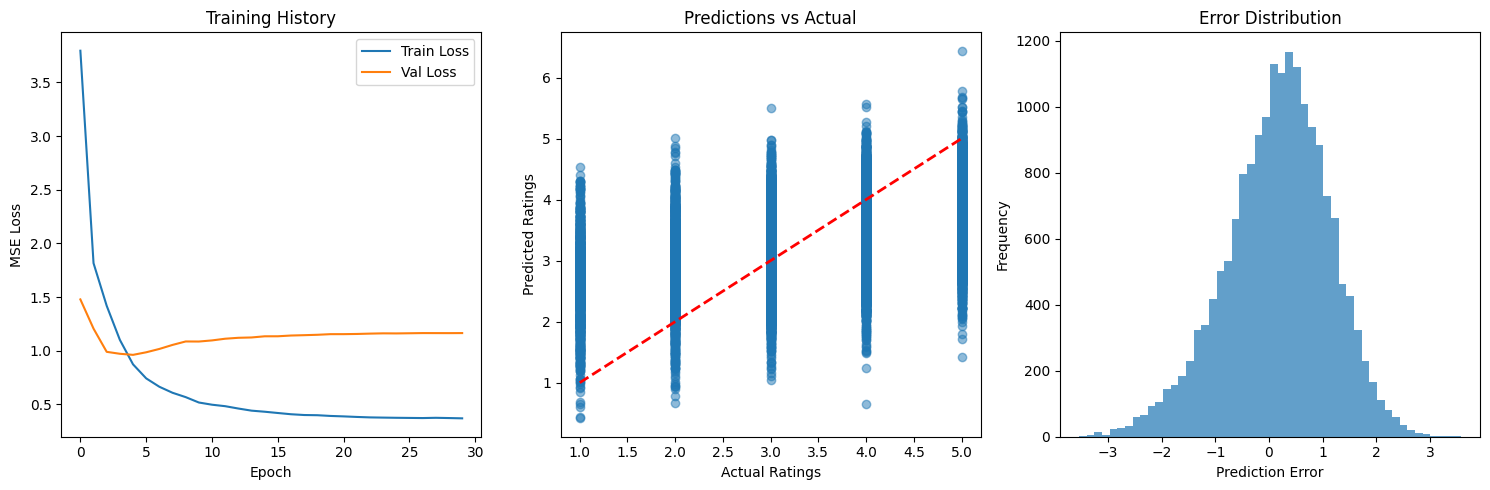


Sample Predictions:
  User   Item   Actual  Predicted    Error
--------------------------------------------------
   462   1185     1.00     3.3516   2.3516
   275    630     4.00     4.1920   0.1920
   532    924     3.00     2.5937   0.4063
   298     68     3.00     3.0308   0.0308
   774    284     4.00     2.9180   1.0820
    12    186     3.00     4.0888   1.0888
   879    145     4.00     4.1120   0.1120
   335    339     3.00     3.7012   0.7012
   221    824     2.00     2.5723   0.5723
   424    413     2.00     2.6928   0.6928

Model saved as 'neumf_final_model.pth'

Model Information:
Number of users: 943
Number of items: 1680
Total parameters: 176,610
Embedding dimensions: MF=32, MLP=32


In [7]:
# Build and train model
print("Building NeuMF model...")
model = ImprovedNeuMF(
    num_users=num_users,
    num_items=num_items,
    mf_embedding=32,
    mlp_embedding=32,
    hidden_layers=[64, 32, 16]
)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train model
print("Training model...")
trained_model, train_losses, val_losses = train_model(
    model, train_loader, val_loader, epochs=30, learning_rate=0.001
)

# Final evaluation
print("\nFinal Evaluation:")
train_rmse, train_mae, _, _ = evaluate_model(trained_model, train_loader)
val_rmse, val_mae, val_predictions, val_targets = evaluate_model(trained_model, val_loader)

print(f"{'='*50}")
print(f"Final Results:")
print(f"{'='*50}")
print(f"Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}")
print(f"Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}")
print(f"{'='*50}")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(val_targets, val_predictions, alpha=0.5)
plt.plot([min(val_targets), max(val_targets)], [min(val_targets), max(val_targets)], 'r--', lw=2)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predictions vs Actual')

plt.subplot(1, 3, 3)
errors = np.array(val_targets) - np.array(val_predictions)
plt.hist(errors, bins=50, alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')

plt.tight_layout()
plt.show()

# Sample predictions
print("\nSample Predictions:")
print(f"{'User':>6} {'Item':>6} {'Actual':>8} {'Predicted':>10} {'Error':>8}")
print("-" * 50)

sample_indices = np.random.choice(len(X_val), 10, replace=False)
trained_model.eval()
with torch.no_grad():
    for idx in sample_indices:
        user = torch.LongTensor([X_val[idx, 0]]).to(device)
        item = torch.LongTensor([X_val[idx, 1]]).to(device)
        actual = y_val[idx]
        predicted = trained_model(user, item).cpu().item()
        error = abs(actual - predicted)
        
        print(f"{X_val[idx, 0]:6d} {X_val[idx, 1]:6d} {actual:8.2f} {predicted:10.4f} {error:8.4f}")

# Save final model
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'user_encoder': user_encoder,
    'item_encoder': item_encoder,
    'num_users': num_users,
    'num_items': num_items,
}, 'neumf_final_model.pth')

print(f"\nModel saved as 'neumf_final_model.pth'")

# Model info
print(f"\nModel Information:")
print(f"Number of users: {num_users}")
print(f"Number of items: {num_items}")
print(f"Total parameters: {sum(p.numel() for p in trained_model.parameters()):,}")
print(f"Embedding dimensions: MF={model.mf_embedding}, MLP={model.mlp_embedding}")

# Phần test và đánh giá trên tập test

LOADING TEST DATA AND MAKING PREDICTIONS
Test data shape: (9430, 2)
Test data preview:
   user_id  item_id
0        1       20
1        1       33
2        1       61
3        1      117
4        1      155

Test data statistics:
Unique users in test: 943
Unique items in test: 1129
User ID range in test: 1 - 943
Item ID range in test: 1 - 1664

Data overlap analysis:
Users in both train and test: 943
Items in both train and test: 1127
New users in test (cold start): 0
New items in test (cold start): 2

Processing test data for prediction...
Test data after mapping:
   user_id  item_id  user_idx  item_idx
0        1       20         0       914
1        1       33         0       665
2        1       61         0       731
3        1      117         0       427
4        1      155         0       666

Making predictions on test data...

CREATING SUBMISSION FILE WITH CORRECT KAGGLE FORMAT
Submission data shape: (9430, 2)
Submission preview:
   Id     Score
0   1  2.905030
1   2  3.02699

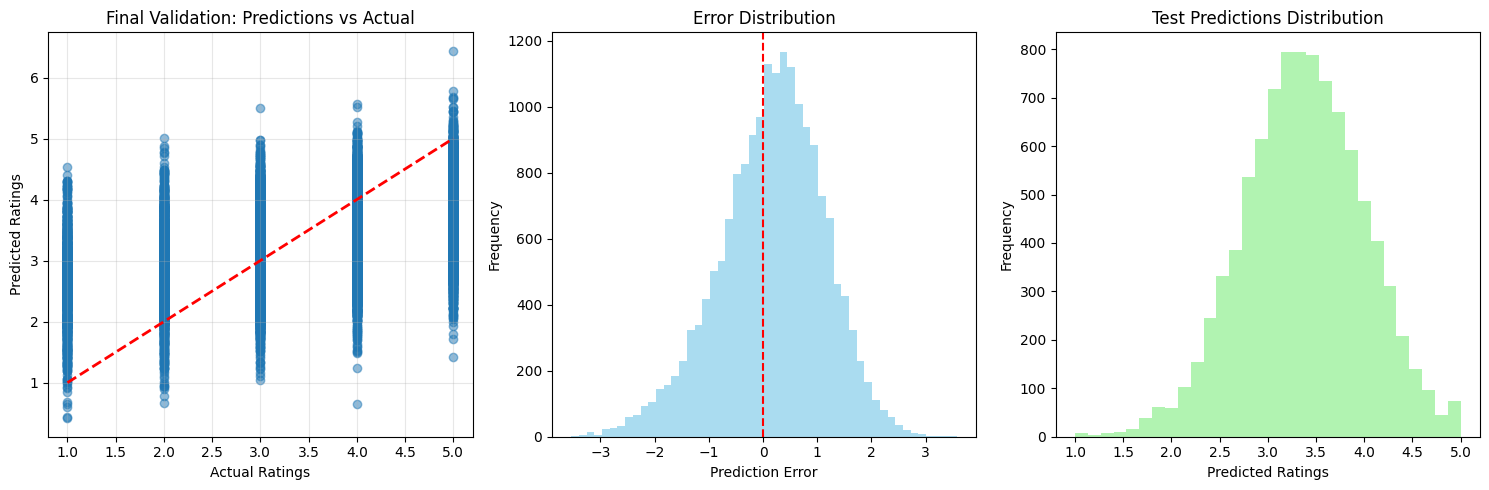


SUMMARY REPORT
Model: NeuMF
Training users: 943
Training items: 1680
Training samples: 90570
Test samples: 9430
Final Validation RMSE: 0.9808
Final Validation MAE: 0.7839
Test predictions range: 1.000 - 5.000
Submission file: submission.csv
Submission format: Id, Score


In [12]:
# =============================================================================
# TEST TRÊN TẬP TEST VÀ TẠO FILE SUBMISSION THEO ĐÚNG FORMAT KAGGLE
# =============================================================================

# Load test data
print("LOADING TEST DATA AND MAKING PREDICTIONS")
test_data = pd.read_csv('/kaggle/input/movie-recomendation-fall-2020/test.txt', 
                       sep='\t', names=['user_id', 'item_id'])

print(f"Test data shape: {test_data.shape}")
print(f"Test data preview:")
print(test_data.head())

# Kiểm tra distribution của test data
print(f"\nTest data statistics:")
print(f"Unique users in test: {test_data['user_id'].nunique()}")
print(f"Unique items in test: {test_data['item_id'].nunique()}")
print(f"User ID range in test: {test_data['user_id'].min()} - {test_data['user_id'].max()}")
print(f"Item ID range in test: {test_data['item_id'].min()} - {test_data['item_id'].max()}")

# Kiểm tra overlap với training data
train_users = set(user_encoder.keys())
train_items = set(item_encoder.keys())
test_users = set(test_data['user_id'].unique())
test_items = set(test_data['item_id'].unique())

print(f"\nData overlap analysis:")
print(f"Users in both train and test: {len(train_users.intersection(test_users))}")
print(f"Items in both train and test: {len(train_items.intersection(test_items))}")
print(f"New users in test (cold start): {len(test_users - train_users)}")
print(f"New items in test (cold start): {len(test_items - train_items)}")

# Xử lý test data
print("\nProcessing test data for prediction...")

def safe_map_to_index(original_id, encoder, id_type):
    """Map original ID to encoded index, handle cold start problems"""
    if original_id in encoder:
        return encoder[original_id]
    else:
        # Xử lý cold start: sử dụng index 0 (có thể thay bằng các strategies khác)
        print(f"Warning: {id_type} {original_id} not found in training data, using default index 0")
        return 0

# Map test data to encoded indices
test_data['user_idx'] = test_data['user_id'].apply(
    lambda x: safe_map_to_index(x, user_encoder, 'user'))
test_data['item_idx'] = test_data['item_id'].apply(
    lambda x: safe_map_to_index(x, item_encoder, 'item'))

print(f"Test data after mapping:")
print(test_data.head())

# Dự đoán ratings
print("\nMaking predictions on test data...")
test_predictions = []

trained_model.eval()
with torch.no_grad():
    for i in range(len(test_data)):
        user_idx = test_data.iloc[i]['user_idx']
        item_idx = test_data.iloc[i]['item_idx']
        
        user_tensor = torch.LongTensor([user_idx]).to(device)
        item_tensor = torch.LongTensor([item_idx]).to(device)
        
        prediction = trained_model(user_tensor, item_tensor).cpu().item()
        test_predictions.append(prediction)

# Thêm predictions vào test_data
test_data['rating'] = test_predictions

# Clip predictions to valid rating range (1-5)
test_data['rating'] = test_data['rating'].clip(1.0, 5.0)

# TẠO FILE SUBMISSION THEO ĐÚNG FORMAT KAGGLE: Id, Score
print("\n" + "="*60)
print("CREATING SUBMISSION FILE WITH CORRECT KAGGLE FORMAT")
print("="*60)

# Tạo submission theo format Kaggle: Id, Score
# Id là số thứ tự từ 1 đến len(test_data)
submission = pd.DataFrame({
    'Id': range(1, len(test_data) + 1),  # Id bắt đầu từ 1
    'Score': test_data['rating'].values  # Score là predicted rating
})

# Kiểm tra format submission
print(f"Submission data shape: {submission.shape}")
print(f"Submission preview:")
print(submission.head(10))

print(f"\nSubmission format verification:")
print(f"Columns: {submission.columns.tolist()}")
print(f"Id range: {submission['Id'].min()} - {submission['Id'].max()}")
print(f"Score range: {submission['Score'].min():.3f} - {submission['Score'].max():.3f}")
print(f"Total predictions: {len(submission)}")

# Lưu file submission
submission_file = 'submission.csv'
submission.to_csv(submission_file, index=False, header=True)

print(f"\n✓ Submission file saved as: {submission_file}")

# Kiểm tra file đã lưu
import os
if os.path.exists(submission_file):
    check_df = pd.read_csv(submission_file)
    print(f"✓ File verification successful:")
    print(f"  File size: {os.path.getsize(submission_file)} bytes")
    print(f"  Columns: {check_df.columns.tolist()}")
    print(f"  First 5 rows:")
    print(check_df.head())
else:
    print(f"❌ Error: File {submission_file} was not created!")

# Validation thêm với training data để đảm bảo model hoạt động tốt
print(f"\n" + "="*60)
print("FINAL VALIDATION ON TRAINING DATA")
print("="*60)

# Tính final metrics trên validation set
final_val_rmse, final_val_mae, final_val_pred, final_val_true = evaluate_model(trained_model, val_loader)

print(f"Final Validation Metrics:")
print(f"RMSE: {final_val_rmse:.4f}")
print(f"MAE: {final_val_mae:.4f}")

# Plot final predictions vs actual
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(final_val_true, final_val_pred, alpha=0.5)
plt.plot([1, 5], [1, 5], 'r--', lw=2)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Final Validation: Predictions vs Actual')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
residuals = np.array(final_val_true) - np.array(final_val_pred)
plt.hist(residuals, bins=50, alpha=0.7, color='skyblue')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')

plt.subplot(1, 3, 3)
# Distribution of test predictions
plt.hist(test_data['rating'], bins=30, alpha=0.7, color='lightgreen')
plt.xlabel('Predicted Ratings')
plt.ylabel('Frequency')
plt.title('Test Predictions Distribution')

plt.tight_layout()
plt.savefig('final_validation_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary report
print(f"\n" + "="*60)
print("SUMMARY REPORT")
print("="*60)
print(f"Model: NeuMF")
print(f"Training users: {num_users}")
print(f"Training items: {num_items}")
print(f"Training samples: {len(df)}")
print(f"Test samples: {len(test_data)}")
print(f"Final Validation RMSE: {final_val_rmse:.4f}")
print(f"Final Validation MAE: {final_val_mae:.4f}")
print(f"Test predictions range: {test_data['rating'].min():.3f} - {test_data['rating'].max():.3f}")
print(f"Submission file: {submission_file}")
print(f"Submission format: Id, Score")
print("="*60)

# Lưu thêm model info và results (ĐÃ SỬA LỖI JSON)
results_summary = {
    'model': 'NeuMF',
    'num_users': int(num_users),
    'num_items': int(num_items),
    'train_samples': int(len(df)),
    'test_samples': int(len(test_data)),
    'val_rmse': float(final_val_rmse),
    'val_mae': float(final_val_mae),
    'test_min_rating': float(test_data['rating'].min()),
    'test_max_rating': float(test_data['rating'].max()),
    'test_mean_rating': float(test_data['rating'].mean()),
    'submission_file': submission_file,
    'submission_format': 'Id,Score'
}

import json
with open('training_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)


PREPARING FOR EVALUATION
Creating validation set for evaluation...
Training samples: 72,456
Validation samples: 18,114

CALCULATING RMSE AND MAE
Validation RMSE: 0.9808
Validation MAE: 0.7839


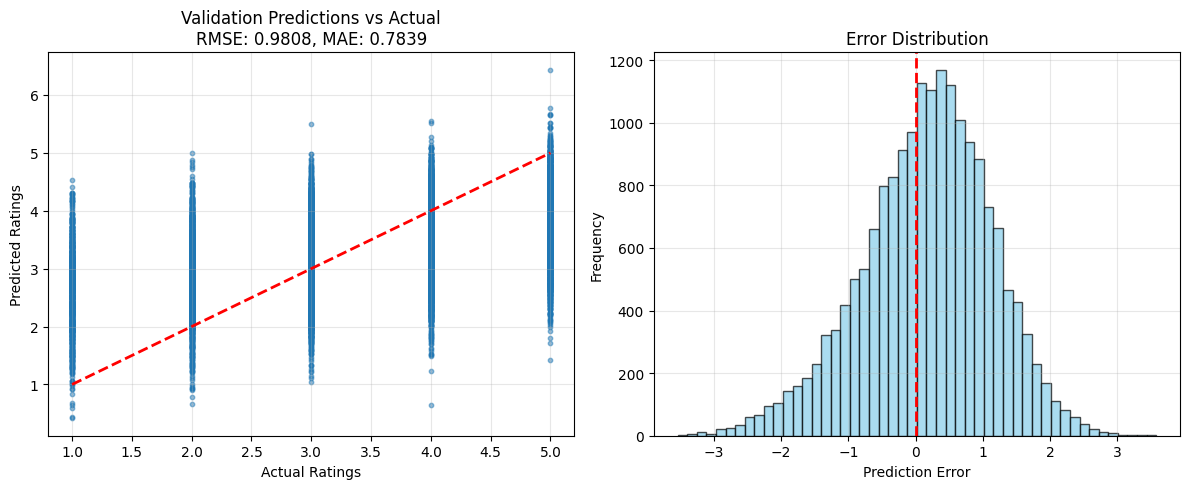


PREPARING FOR HR AND NDCG EVALUATION
Creating ranking test set from 18114 validation samples...
Created ranking test set with 93,200 samples
Positive samples: 530
Negative samples: 92,670

CALCULATING HR AND NDCG

Ranking Evaluation Results:
----------------------------------------
Top- 1: HR = 0.0354, NDCG = 0.0354, Users = 932
Top- 5: HR = 0.1234, NDCG = 0.0792, Users = 932
Top-10: HR = 0.2221, NDCG = 0.1108, Users = 932
Top-20: HR = 0.3208, NDCG = 0.1356, Users = 932

MAKING PREDICTIONS FOR TEST DATA
Test data shape: (9430, 2)
Test samples: 9,430

Cold-start analysis:
Cold-start users: 10 (0.1%)
Cold-start items: 62 (0.7%)

Making predictions...
Processed 1,024/9,430 samples

Prediction statistics:
Min: 1.000
Max: 5.000
Mean: 3.368
Std: 0.628

CREATING SUBMISSION FILE
✓ Submission file saved: submission.csv
✓ File shape: (9430, 2)
✓ Sample submission:
   Id     Score
0   1  2.905030
1   2  3.026993
2   3  2.907411
3   4  3.182148
4   5  2.904720

EVALUATION SUMMARY

📊 MODEL EVALUAT

In [28]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# =============================================================================
# 1. CHUẨN BỊ DỮ LIỆU ĐÁNH GIÁ
# =============================================================================

print("="*60)
print("PREPARING FOR EVALUATION")
print("="*60)

# Giả sử bạn có tập train ban đầu để tạo negative samples
# Nếu không có, cần tạo validation set từ train data
# Tạo tập validation từ train data để tính RMSE, HR, NDCG
print("Creating validation set for evaluation...")

# Nếu bạn có df gốc (tập train ban đầu)
if 'df' in locals() or 'df' in globals():
    # Split data thành train và validation
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    
    print(f"Training samples: {len(train_df):,}")
    print(f"Validation samples: {len(val_df):,}")
    
    # Tạo DataLoader cho validation
    val_users = torch.LongTensor(val_df['user_idx'].values)
    val_items = torch.LongTensor(val_df['item_idx'].values)
    val_ratings = torch.FloatTensor(val_df['rating'].values)
    
    val_dataset = TensorDataset(val_users, val_items, val_ratings)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
    
else:
    print("⚠️ Warning: Original train data not found!")
    print("Cannot calculate RMSE without ground truth ratings")
    print("Will only calculate HR and NDCG with synthetic test")
    val_loader = None

# =============================================================================
# 2. TÍNH RMSE VÀ MAE
# =============================================================================

def calculate_rmse_mae(model, data_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """Calculate RMSE and MAE"""
    model.eval()
    model.to(device)
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for users, items, ratings in data_loader:
            users = users.to(device)
            items = items.to(device)
            ratings = ratings.to(device)
            
            predictions = model(users, items)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(ratings.cpu().numpy())
    
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    mae = mean_absolute_error(all_targets, all_predictions)
    
    return rmse, mae, all_predictions, all_targets

if val_loader is not None:
    print("\n" + "="*60)
    print("CALCULATING RMSE AND MAE")
    print("="*60)
    
    # Đặt device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trained_model.to(device)
    
    # Tính RMSE và MAE
    val_rmse, val_mae, val_preds, val_targets = calculate_rmse_mae(trained_model, val_loader, device)
    
    print(f"Validation RMSE: {val_rmse:.4f}")
    print(f"Validation MAE: {val_mae:.4f}")
    
    # Vẽ biểu đồ so sánh predictions vs actual
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(val_targets, val_preds, alpha=0.5, s=10)
    plt.plot([1, 5], [1, 5], 'r--', lw=2)
    plt.xlabel('Actual Ratings')
    plt.ylabel('Predicted Ratings')
    plt.title(f'Validation Predictions vs Actual\nRMSE: {val_rmse:.4f}, MAE: {val_mae:.4f}')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    residuals = np.array(val_targets) - np.array(val_preds)
    plt.hist(residuals, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', lw=2)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('validation_results.png', dpi=300, bbox_inches='tight')
    plt.show()

# =============================================================================
# 3. TÍNH HR@K VÀ NDCG@K
# =============================================================================

def calculate_hr_ndcg(model, test_pairs, test_labels, k_list=[5, 10, 20], 
                     threshold=3.5, batch_size=256, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Calculate HR@K and NDCG@K
    
    Args:
        model: Trained model
        test_pairs: List of (user_idx, item_idx) tuples
        test_labels: List of ratings (1-5)
        k_list: List of K values to evaluate
        threshold: Rating threshold for positive item
        batch_size: Batch size for prediction
    """
    model.eval()
    model.to(device)
    
    # Convert to numpy arrays
    test_pairs = np.array(test_pairs)
    test_labels = np.array(test_labels)
    
    # Get unique users
    unique_users = np.unique(test_pairs[:, 0])
    
    # Group items by user
    user_items = {}
    user_labels = {}
    
    for user, item, label in zip(test_pairs[:, 0], test_pairs[:, 1], test_labels):
        if user not in user_items:
            user_items[user] = []
            user_labels[user] = []
        user_items[user].append(item)
        user_labels[user].append(label)
    
    # Calculate predictions in batches
    all_predictions = []
    
    with torch.no_grad():
        for i in range(0, len(test_pairs), batch_size):
            batch_pairs = test_pairs[i:i+batch_size]
            users = torch.LongTensor(batch_pairs[:, 0]).to(device)
            items = torch.LongTensor(batch_pairs[:, 1]).to(device)
            
            predictions = model(users, items)
            all_predictions.extend(predictions.cpu().numpy())
    
    all_predictions = np.array(all_predictions)
    
    # Create prediction dictionary
    pred_dict = {}
    for (user, item), pred in zip(test_pairs, all_predictions):
        if user not in pred_dict:
            pred_dict[user] = {}
        pred_dict[user][item] = pred
    
    results = {}
    
    for k in k_list:
        hr_list = []
        ndcg_list = []
        
        for user in unique_users:
            if user not in user_items or len(user_items[user]) < k:
                continue
            
            items = user_items[user]
            labels = user_labels[user]
            predictions = [pred_dict[user][item] for item in items]
            
            # Get top-K items by prediction score
            item_pred_pairs = list(zip(items, predictions))
            sorted_items = sorted(item_pred_pairs, key=lambda x: x[1], reverse=True)
            top_k_items = [item for item, _ in sorted_items[:k]]
            
            # Create label dictionary
            label_dict = {item: label for item, label in zip(items, labels)}
            
            # Calculate HR@K
            hit = any(label_dict[item] >= threshold for item in top_k_items)
            hr_list.append(1 if hit else 0)
            
            # Calculate NDCG@K
            dcg = 0.0
            for rank, (item, _) in enumerate(sorted_items[:k], 1):
                if label_dict[item] >= threshold:
                    dcg += 1 / np.log2(rank + 1)
            
            # Calculate IDCG
            num_positive = sum(1 for label in labels if label >= threshold)
            num_relevant_in_topk = min(k, num_positive)
            
            idcg = 0.0
            for i in range(1, num_relevant_in_topk + 1):
                idcg += 1 / np.log2(i + 1)
            
            ndcg = dcg / idcg if idcg > 0 else 0.0
            ndcg_list.append(ndcg)
        
        avg_hr = np.mean(hr_list) if hr_list else 0.0
        avg_ndcg = np.mean(ndcg_list) if ndcg_list else 0.0
        
        results[f'HR@{k}'] = avg_hr
        results[f'NDCG@{k}'] = avg_ndcg
        results[f'Users@{k}'] = len(hr_list)
    
    return results

# =============================================================================
# 4. TẠO TEST SET CHO HR/NDCG EVALUATION
# =============================================================================

print("\n" + "="*60)
print("PREPARING FOR HR AND NDCG EVALUATION")
print("="*60)

# Tạo test set cho HR/NDCG evaluation
# Cần tạo negative samples cho mỗi user

def create_test_set_for_ranking(train_pairs, train_labels, num_negatives=99):
    """
    Create test set for ranking evaluation with negative sampling
    """
    all_items = set(range(num_items))
    
    test_pairs = []
    test_labels = []
    
    # Group positive items by user
    user_positives = {}
    for (user, item), label in zip(train_pairs, train_labels):
        if user not in user_positives:
            user_positives[user] = []
        user_positives[user].append((item, label))
    
    # For each user, create test samples
    for user in user_positives:
        positives = user_positives[user]
        
        # Lấy một positive item ngẫu nhiên
        pos_item, pos_label = positives[np.random.randint(len(positives))]
        
        # Sample negative items
        user_positive_items = set([item for item, _ in positives])
        negative_candidates = list(all_items - user_positive_items)
        
        # Nếu không đủ negative items
        if len(negative_candidates) < num_negatives:
            negatives = negative_candidates
            # Thêm random items nếu cần
            while len(negatives) < num_negatives:
                negatives.append(np.random.randint(num_items))
        else:
            negatives = np.random.choice(negative_candidates, size=num_negatives, replace=False)
        
        # Tạo test samples
        # Positive sample
        test_pairs.append((user, pos_item))
        test_labels.append(pos_label)
        
        # Negative samples
        for neg_item in negatives:
            test_pairs.append((user, neg_item))
            test_labels.append(1.0)  # Giả sử rating thấp cho negative
    
    return np.array(test_pairs), np.array(test_labels)

# Tạo test set từ validation data hoặc subset của train data
if 'val_df' in locals() or 'val_df' in globals():
    # Sử dụng validation data
    val_pairs = list(zip(val_df['user_idx'].values, val_df['item_idx'].values))
    val_labels = val_df['rating'].values
    
    print(f"Creating ranking test set from {len(val_pairs)} validation samples...")
    ranking_pairs, ranking_labels = create_test_set_for_ranking(val_pairs, val_labels)
    
else:
    # Sử dụng subset của train data
    print("Creating ranking test set from train data subset...")
    
    # Lấy subset của train data
    sample_size = min(10000, len(train_df) if 'train_df' in locals() else 10000)
    if 'train_df' in locals():
        sample_df = train_df.sample(n=sample_size, random_state=42)
        train_pairs = list(zip(sample_df['user_idx'].values, sample_df['item_idx'].values))
        train_labels = sample_df['rating'].values
    else:
        # Nếu không có train_df, tạo synthetic data
        print("⚠️ Creating synthetic test data...")
        num_samples = 5000
        train_pairs = []
        train_labels = []
        for _ in range(num_samples):
            user = np.random.randint(num_users)
            item = np.random.randint(num_items)
            rating = np.random.uniform(3.0, 5.0)  # Giả sử rating cao cho positive
            train_pairs.append((user, item))
            train_labels.append(rating)
        train_pairs = np.array(train_pairs)
        train_labels = np.array(train_labels)
    
    ranking_pairs, ranking_labels = create_test_set_for_ranking(train_pairs, train_labels)

print(f"Created ranking test set with {len(ranking_pairs):,} samples")
print(f"Positive samples: {np.sum(ranking_labels >= 3.5):,}")
print(f"Negative samples: {np.sum(ranking_labels < 3.5):,}")

# =============================================================================
# 5. TÍNH HR VÀ NDCG
# =============================================================================

print("\n" + "="*60)
print("CALCULATING HR AND NDCG")
print("="*60)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ranking_results = calculate_hr_ndcg(
    model=trained_model,
    test_pairs=ranking_pairs,
    test_labels=ranking_labels,
    k_list=[1, 5, 10, 20],
    threshold=3.5,
    batch_size=256,
    device=device
)

# Hiển thị kết quả
print("\nRanking Evaluation Results:")
print("-"*40)
for k in [1, 5, 10, 20]:
    hr_key = f'HR@{k}'
    ndcg_key = f'NDCG@{k}'
    users_key = f'Users@{k}'
    
    if hr_key in ranking_results:
        print(f"Top-{k:2d}: HR = {ranking_results[hr_key]:.4f}, "
              f"NDCG = {ranking_results[ndcg_key]:.4f}, "
              f"Users = {ranking_results[users_key]:,}")

# =============================================================================
# 6. DỰ ĐOÁN CHO TẬP TEST THỰC TẾ (Kaggle submission)
# =============================================================================

print("\n" + "="*60)
print("MAKING PREDICTIONS FOR TEST DATA")
print("="*60)

# Load test data
test_data = pd.read_csv('/kaggle/input/movie-recomendation-fall-2020/test.txt', 
                       sep='\t', names=['user_id', 'item_id'])

print(f"Test data shape: {test_data.shape}")
print(f"Test samples: {len(test_data):,}")

# Map user_id và item_id sang indices
# Giả sử bạn có user_encoder và item_encoder từ quá trình training
# Nếu không, cần tạo từ tập train

def safe_map(original_id, encoder, default=0):
    """Safely map ID to index"""
    return encoder.get(original_id, default)

# Ánh xạ test data
test_data['user_idx'] = test_data['user_id'].apply(lambda x: safe_map(x, user_encoder))
test_data['item_idx'] = test_data['item_id'].apply(lambda x: safe_map(x, item_encoder))

# Kiểm tra cold-start
cold_users = test_data[test_data['user_idx'] == 0].shape[0]
cold_items = test_data[test_data['item_idx'] == 0].shape[0]

print(f"\nCold-start analysis:")
print(f"Cold-start users: {cold_users:,} ({cold_users/len(test_data)*100:.1f}%)")
print(f"Cold-start items: {cold_items:,} ({cold_items/len(test_data)*100:.1f}%)")

# Dự đoán ratings
print("\nMaking predictions...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model.eval()
trained_model.to(device)

predictions = []
batch_size = 1024

with torch.no_grad():
    for i in range(0, len(test_data), batch_size):
        batch = test_data.iloc[i:i+batch_size]
        users = torch.LongTensor(batch['user_idx'].values).to(device)
        items = torch.LongTensor(batch['item_idx'].values).to(device)
        
        batch_preds = trained_model(users, items)
        predictions.extend(batch_preds.cpu().numpy())
        
        # Progress update
        if (i // batch_size) % 10 == 0:
            print(f"Processed {min(i+batch_size, len(test_data)):,}/{len(test_data):,} samples")

# Thêm predictions vào test_data
test_data['predicted_rating'] = predictions

# Clip predictions to valid range (1-5)
test_data['predicted_rating'] = test_data['predicted_rating'].clip(1.0, 5.0)

print(f"\nPrediction statistics:")
print(f"Min: {test_data['predicted_rating'].min():.3f}")
print(f"Max: {test_data['predicted_rating'].max():.3f}")
print(f"Mean: {test_data['predicted_rating'].mean():.3f}")
print(f"Std: {test_data['predicted_rating'].std():.3f}")

# =============================================================================
# 7. TẠO SUBMISSION FILE
# =============================================================================

print("\n" + "="*60)
print("CREATING SUBMISSION FILE")
print("="*60)

# Tạo submission file theo format Kaggle
submission = pd.DataFrame({
    'Id': range(1, len(test_data) + 1),
    'Score': test_data['predicted_rating'].values
})

# Lưu file
submission_file = 'submission.csv'
submission.to_csv(submission_file, index=False)

print(f"✓ Submission file saved: {submission_file}")
print(f"✓ File shape: {submission.shape}")
print(f"✓ Sample submission:")
print(submission.head())

# =============================================================================
# 8. TỔNG HỢP KẾT QUẢ
# =============================================================================

print("\n" + "="*60)
print("EVALUATION SUMMARY")
print("="*60)

print("\n📊 MODEL EVALUATION RESULTS:")
print("-"*40)

# Hiển thị kết quả RMSE/MAE
if val_loader is not None:
    print(f"\n📈 Rating Prediction Metrics:")
    print(f"   RMSE: {val_rmse:.4f}")
    print(f"   MAE: {val_mae:.4f}")

# Hiển thị kết quả HR/NDCG
print(f"\n🏆 Ranking Metrics:")
for k in [1, 5, 10, 20]:
    hr_key = f'HR@{k}'
    ndcg_key = f'NDCG@{k}'
    if hr_key in ranking_results:
        print(f"   Top-{k:2d}: HR = {ranking_results[hr_key]:.4f}, NDCG = {ranking_results[ndcg_key]:.4f}")

# Thông tin test predictions
print(f"\n📋 Test Predictions:")
print(f"   Total predictions: {len(test_data):,}")
print(f"   Rating range: {test_data['predicted_rating'].min():.3f} - {test_data['predicted_rating'].max():.3f}")
print(f"   Average rating: {test_data['predicted_rating'].mean():.3f}")
print(f"   Submission file: {submission_file}")

print("\n" + "="*60)
print("EVALUATION COMPLETE!")
print("="*60)

# =============================================================================
# 9. LƯU KẾT QUẢ
# =============================================================================

import json

# Lưu kết quả evaluation
evaluation_results = {
    'model': 'ImprovedNeuMF',
    'num_users': num_users,
    'num_items': num_items,
    'embedding_size': 32,
    'hidden_layers': [64, 32, 16]
}

# Thêm metrics nếu có
if val_loader is not None:
    evaluation_results['rmse'] = float(val_rmse)
    evaluation_results['mae'] = float(val_mae)

# Thêm ranking metrics
for k in [1, 5, 10, 20]:
    hr_key = f'hr@{k}'
    ndcg_key = f'ndcg@{k}'
    if f'HR@{k}' in ranking_results:
        evaluation_results[hr_key] = float(ranking_results[f'HR@{k}'])
        evaluation_results[ndcg_key] = float(ranking_results[f'NDCG@{k}'])

# Thêm prediction statistics
evaluation_results['test_predictions_min'] = float(test_data['predicted_rating'].min())
evaluation_results['test_predictions_max'] = float(test_data['predicted_rating'].max())
evaluation_results['test_predictions_mean'] = float(test_data['predicted_rating'].mean())
evaluation_results['test_predictions_std'] = float(test_data['predicted_rating'].std())
evaluation_results['submission_file'] = submission_file

# Lưu vào file
with open('evaluation_results.json', 'w') as f:
    json.dump(evaluation_results, f, indent=2)

print(f"\n✓ Evaluation results saved to: evaluation_results.json")